In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import random
from scipy.optimize import curve_fit

import ctypes
import numba as nb

# Problem 1

Fit parameter a: -0.00026 +\- 0.00576
Fit parameter b: 0.002 +\- 0.00573


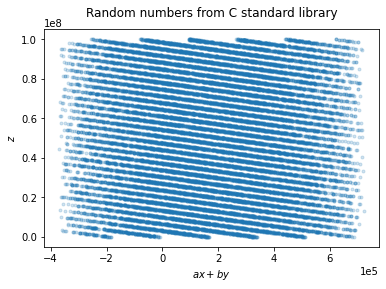

In [2]:
# ----------- First, retrieve the data --------------------------

rows = []
with open("rand_points.txt","r") as f:
    for i in f.readlines():
        cols = []
        for j in i.split():
            cols.append(int(j))
        rows.append(cols)
        
rows = np.asarray(rows)
x = rows[:,0]
y = rows[:,1]
z = rows[:,2]

# ------------------ Suitably choose a and b using scipy -----------------------------------

def fun(data,a,b,c):
    return a*data[:,0]+b*data[:,1]+c

popt, pcov = curve_fit(fun, np.stack([x,y]).T, z)

# Print the fit parameters and their uncertainties
print("Fit parameter a:",round(popt[0],5),"+\-",round(np.sqrt(np.diag(pcov))[0],5))
print("Fit parameter b:",round(popt[1],5),"+\-",round(np.sqrt(np.diag(pcov))[1],5))

# Play around with it a little -- scipy isn't perfect!
a = popt[0] + 1.3*np.sqrt(np.diag(pcov))[0]
b = popt[1] - np.sqrt(np.diag(pcov))[1]

# ------------------------- Plot the result! -----------------------------------------------

plt.plot(a*x+b*y, z, '.', alpha=0.2)
plt.ylabel(r"$z$")
plt.xlabel(r"$ax+by$")
plt.title("Random numbers from C standard library",y=1.03)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

#plt.savefig("problem1_broken.png",dpi=500,bbox_inches='tight')

plt.show()


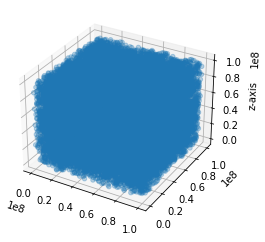

In [3]:
# ------------- Also show the corresponding 3d plot ---------------------------------

# %matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(x,y,z,alpha=0.3)
ax.set_zlabel('z-axis')
plt.show()

In [ ]:
# -------------------- Try again with Python's RNG -------------------------------

# Get a huge list of random numbers
n=300000000

# Initialize empty array
vec = np.empty(3*n, dtype='int32')

# Fill it with random numbers
for i in tqdm(range(vec.size)):
    vec[i] = random.randint(0,int(2**31))

# Split it into 3 columns
vv = np.reshape(vec, [n,3])

# Only keep values smaller than maxval
vmax = np.max(vv,axis=1)
maxval = 1e8
vv2 = vv[vmax<maxval,:]

# Save them because it takes a really long time to run this!
with open("rand_points_python.txt","w") as f:
    for i in range(vv2.shape[0]):
        myline = repr(vv2[i,0])+' '+repr(vv2[i,1])+' '+ repr(vv2[i,2])+'\n'
        f.write(myline)

In [ ]:
# -------------------- Check to see if Python random numbers are correlated ----------------------------

x_p = vv2[:,0]
y_p = vv2[:,1]
z_p = vv2[:,2]

popt_p, pcov_p = curve_fit(fun, np.stack([x_p,y_p]).T, z_p)

# Print the fit parameters and their uncertainties
print("Fit parameter a:",round(popt_p[0],5),"+\-",round(np.sqrt(np.diag(pcov_p))[0],5))
print("Fit parameter b:",round(popt_p[1],5),"+\-",round(np.sqrt(np.diag(pcov_p))[1],5))

a_p = popt_p[0] 
b_p = popt_p[1] 

# ------------------------- Plot the result! -----------------------------------------------

plt.plot(a_p*x_p+b_p*y_p, z_p, '.', alpha=0.2)
plt.ylabel(r"$z$")
plt.xlabel(r"$ax+by$")
plt.title("Random numbers from Python's random module",y=1.03)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.savefig("problem1_unbroken.png",dpi=500,bbox_inches='tight')

plt.show()

In [4]:
# ----------------------- Finally, try the C standard library on my computer -----------------------

# Below: basically copy-pasted from test_broken_libc.py

####################################################################################################

mylib=ctypes.cdll.LoadLibrary("libc.so.6")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int


@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=300000000
vec=get_rands(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv_me=vv[vmax<maxval,:]

f=open('rand_points_me.txt','w')
for i in range(vv_me.shape[0]):
    myline=repr(vv_me[i,0])+' '+repr(vv_me[i,1])+' '+ repr(vv_me[i,2])+'\n'
    f.write(myline)
f.close()

####################################################################################################

Fit parameter a: -0.00478 +\- 0.00573
Fit parameter b: -0.01389 +\- 0.00577


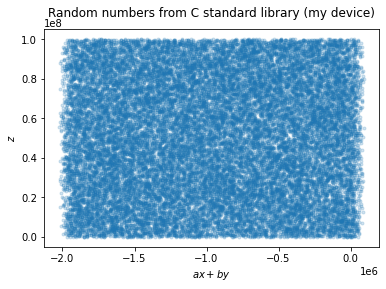

In [12]:
# -------------------- Find the correlation for my random numbers ----------------------------

x_me = vv_me[:,0]
y_me = vv_me[:,1]
z_me = vv_me[:,2]

popt_me, pcov_me = curve_fit(fun, np.stack([x_me,y_me]).T, z_me)

# Print the fit parameters and their uncertainties
print("Fit parameter a:",round(popt_me[0],5),"+\-",round(np.sqrt(np.diag(pcov_me))[0],5))
print("Fit parameter b:",round(popt_me[1],5),"+\-",round(np.sqrt(np.diag(pcov_me))[1],5))

# Play around with it a little -- scipy isn't perfect!
a_me = popt_me[0] + 1*np.sqrt(np.diag(pcov_me))[0]
b_me = popt_me[1] - 1.1*np.sqrt(np.diag(pcov_me))[1]

# ------------------------- Plot the result! -----------------------------------------------

plt.plot(a_me*x_me+b_me*y_me, z_me, '.', alpha=0.2)
plt.ylabel(r"$z$")
plt.xlabel(r"$ax+by$")
plt.title("Random numbers from C standard library (my device)",y=1.03)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.savefig("problem1_broken_me.png",dpi=500,bbox_inches='tight')

plt.show()

# Problem 2